In [1]:
!date

Wed Mar  5 11:36:31 EST 2025


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Data/StudyForrest'

In [4]:
import nbformat
import os
from tqdm import tqdm
import shutil
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from matplotlib import pyplot as plt

In [5]:
import pickle
def load_pickle(filename):
    with open(filename,"rb") as filehandler:
        dump = pickle.load(filehandler)
    return dump

In [6]:
model_names = ['conv_denoise',
'conv_denoise500',
'conv_denoise_bn',
'conv_denoise_large',
'conv_denoise_large500',
'conv_smooth',
'conv_smooth-small',
'conv_weights_unet_denoise',
'conv_weights_unet_denoise500',]
model_names.sort()

In [7]:
errors = []

In [ ]:
for rep in tqdm([1,2,3,4,5,6,7,8,9,10]):
    analysis_name = f'new-stefano-conv-allSubs-rep-{rep}'
    notebooks_dir = os.path.join('./DeepCor-papermill',analysis_name)
    notebooks = [f for f in os.listdir(notebooks_dir) if f.endswith('.ipynb')]
    notebooks.sort()
    n = len(notebooks)
    #print(n)
    for s in range(14):
    #for s in tqdm([1,2,3,4,5,6,7,8,9,11,12,13,14]):
        for r in [1,2,3,4]:
            notebook_path = os.path.join(notebooks_dir,f'ensembling-method-S{s}-R{r}.ipynb')
            if os.path.exists(notebook_path):
                assert os.path.exists(notebook_path),'bad path'
                
                with open(notebook_path, 'r', encoding='utf-8') as f:
                    notebook = nbformat.read(f, as_version=4)
                    
                target_outputs = []
                for cell in notebook['cells']:
                    if cell['cell_type'] == 'code' and 'save_derivs(weights_ofn)' in cell['source']:
                        # Check if the cell has outputs
                        if 'outputs' in cell:
                            for output in cell['outputs']:
                                # Extract the text output if available
                                if output['output_type'] == 'stream' and 'text' in output and 'saved as' in output['text']:
                                    #target_outputs.append(output['text'])
                                    target_outputs.append('../'+output['text'].replace("\n",'').replace('saved as: ',''))
                                    #target_outputs = ['../'+val.replace("\n",'').replace('saved as: ','') for val in target_outputs]
                                    target_outputs.sort()
    
                #if len(target_outputs)!=9: errors.append(f'not 9 files in {notebook_path}')
                #assert len(target_outputs)==9,f'not 9 files in {notebook_path}'
                if len(target_outputs)==9:
                    for i in range(len(target_outputs)):
                        src = target_outputs[i]
                        dst = os.path.join('./stefano-pretraining-organized/',f'{model_names[i]}-S_{s}-R_{r}-rep_{rep}.pickle')
                        shutil.copyfile(src,dst)

In [8]:

done_check = np.array([[all([os.path.exists(os.path.join(os.path.join('./stefano-pretraining-organized/',f'{model_names[0]}-S_{s}-R_{r}-rep_{rep}.pickle'))) for r in [1,2,3,4]]) for s in range(14)] for rep in range(11)])


Text(0.5, 0, 'repetition')

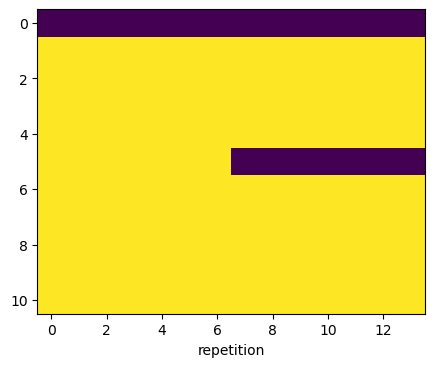

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(done_check);
plt.xlabel('subject')
plt.xlabel('repetition')

In [10]:
np.nonzero(done_check.mean(axis=1)==1)[0]

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10])

In [11]:
[f'{i:02d}:{model_names[i]}' for i in range(len(model_names))]

['00:conv_denoise',
 '01:conv_denoise500',
 '02:conv_denoise_bn',
 '03:conv_denoise_large',
 '04:conv_denoise_large500',
 '05:conv_smooth',
 '06:conv_smooth-small',
 '07:conv_weights_unet_denoise',
 '08:conv_weights_unet_denoise500']

In [12]:
def get_ensembled_corr(model_name,s,r,reps):
    #dict_keys(['ffa_list', 'signal', 'noise', 'conf_pcs', 'face_reg', 'place_reg', 'contrast_vals', 'corr2face', 'corr2place'])
    pickles = [load_pickle(os.path.join('./stefano-pretraining-organized/',f'{model_name}-S_{s}-R_{r}-rep_{rep}.pickle')) for rep in reps]

    ffa_list = pickles[0]['ffa_list']
    conf_pcs = pickles[0]['conf_pcs']
    
    face_reg = pickles[0]['face_reg']
    place_reg = pickles[0]['place_reg']
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(conf_pcs,ffa_list.transpose());
    ffa_compcorr = ffa_list.transpose()-lin_reg.predict(conf_pcs)
    ffa_compcorr = ffa_compcorr.transpose()
    
    signal = np.median(np.array([pickle['signal'] for pickle in pickles]),axis=0)
    noise = np.median(np.array([pickle['noise'] for pickle in pickles]),axis=0)

    #signal = np.max(np.array([pickle['signal'] for pickle in pickles]),axis=0)
    #noise = np.max(np.array([pickle['noise'] for pickle in pickles]),axis=0)

    #signal = np.median(np.array([pickle['signal'] for pickle in pickles]),axis=0)
    #noise = np.median(np.array([pickle['noise'] for pickle in pickles]),axis=0)

    #top_k = len(pickles)
    #top_k = 3
    #idx = np.argsort([np.corrcoef(pickle['signal'].mean(axis=0),ffa_list.mean(axis=0))[0,1]**2 for pickle in pickles])[::-1]
    #signal = np.max(np.array([pickle['signal'] for pickle in pickles])[idx[0:top_k],:,:],axis=0)
    #noise = np.max(np.array([pickle['noise'] for pickle in pickles])[idx[0:top_k],:,:],axis=0)

    # SS_total = ((pickles[0]['ffa_list']-pickles[0]['ffa_list'].mean(axis=0))**2).sum()
    
    # SS_model_signal = ((pickles[0]['ffa_list']-signal)**2).sum()
    # varexp_signal = 1-(SS_model_signal/SS_total)

    # SS_model_noise = ((pickles[0]['ffa_list']-signal)**2).sum()
    # varexp_noise = 1-(SS_model_noise/SS_total)

    res = [np.corrcoef(face_reg,ffa_list.mean(axis=0))[0,1],
    np.corrcoef(face_reg,ffa_compcorr.mean(axis=0))[0,1],
    np.corrcoef(face_reg,signal.mean(axis=0))[0,1]]

    indiv = [np.corrcoef(face_reg,pickle['signal'].mean(axis=0))[0,1] for pickle in pickles]
    return res,indiv

In [13]:
# #def get_ensembled_corr(model_name,s,r,reps):

# print(model_name)
# print(s)
# print(reps)
# s = 12
# r = 3

# #dict_keys(['ffa_list', 'signal', 'noise', 'conf_pcs', 'face_reg', 'place_reg', 'contrast_vals', 'corr2face', 'corr2place'])
# pickles = [load_pickle(os.path.join('./stefano-pretraining-organized/',f'{model_name}-S_{s}-R_{r}-rep_{rep}.pickle')) for rep in reps]

# ffa_list = pickles[0]['ffa_list']
# conf_pcs = pickles[0]['conf_pcs']

# face_reg = pickles[0]['face_reg']
# place_reg = pickles[0]['place_reg']

# lin_reg = linear_model.LinearRegression()
# lin_reg.fit(conf_pcs,ffa_list.transpose());
# ffa_compcorr = ffa_list.transpose()-lin_reg.predict(conf_pcs)
# ffa_compcorr = ffa_compcorr.transpose()

# signal = np.median(np.array([pickle['signal'] for pickle in pickles]),axis=0)
# noise = np.median(np.array([pickle['noise'] for pickle in pickles]),axis=0)

# idx = np.argsort([np.corrcoef(pickle['signal'].mean(axis=0),ffa_list.mean(axis=0))[0,1]**2 for pickle in pickles])[::-1]
# signal = np.median(np.array([pickle['signal'] for pickle in pickles])[idx[0:5],:,:],axis=0)
# noise = np.median(np.array([pickle['noise'] for pickle in pickles])[idx[0:5],:,:],axis=0)



# SS_total = ((pickles[0]['ffa_list']-pickles[0]['ffa_list'].mean(axis=0))**2).sum()

# SS_model_signal = ((pickles[0]['ffa_list']-signal)**2).sum()
# varexp_signal = 1-(SS_model_signal/SS_total)

# SS_model_noise = ((pickles[0]['ffa_list']-signal)**2).sum()
# varexp_noise = 1-(SS_model_noise/SS_total)

# res = [np.corrcoef(face_reg,ffa_list.mean(axis=0))[0,1],
# np.corrcoef(face_reg,ffa_compcorr.mean(axis=0))[0,1],
# np.corrcoef(face_reg,signal.mean(axis=0))[0,1]]

# indiv = [np.corrcoef(face_reg,pickle['signal'].mean(axis=0))[0,1] for pickle in pickles]
# #return res,indiv,varexp_signal,varexp_noise

# res

In [14]:
def pretty_t_test_rel(v1,v2,text=''):
    from scipy.stats import ttest_rel
    # v1 = diff.mean(axis=1)[:,1]
    # v2 = diff.mean(axis=1)[:,2]
    t,p  = ttest_rel(v2,v1)
    d = v2.mean()-v1.mean()
    if p<.001:
        print(text+f'ΔM={d:.2f}, t({v1.shape[0]-1}) = {t:.2f}, p < .001')
    else:
        print(text+f'ΔM={d:.2f}, t({v1.shape[0]-1}) = {t:.2f}, p = {p:.3f}')

In [15]:
model_name = model_names[5]
print(model_name)
s = 0
r = 2
reps = [1,2,3,4,6,7,8,9,10]

conv_smooth


conv_denoise500
(13, 4, 3)
(13, 4, 9)
DeepCor > Preproc: ΔM=0.04, t(12) = 5.00, p < .001
DeepCor > COMPCOR: ΔM=0.02, t(12) = 1.50, p = 0.160


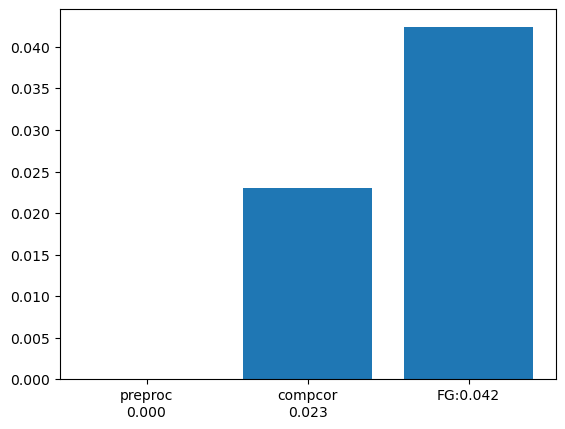

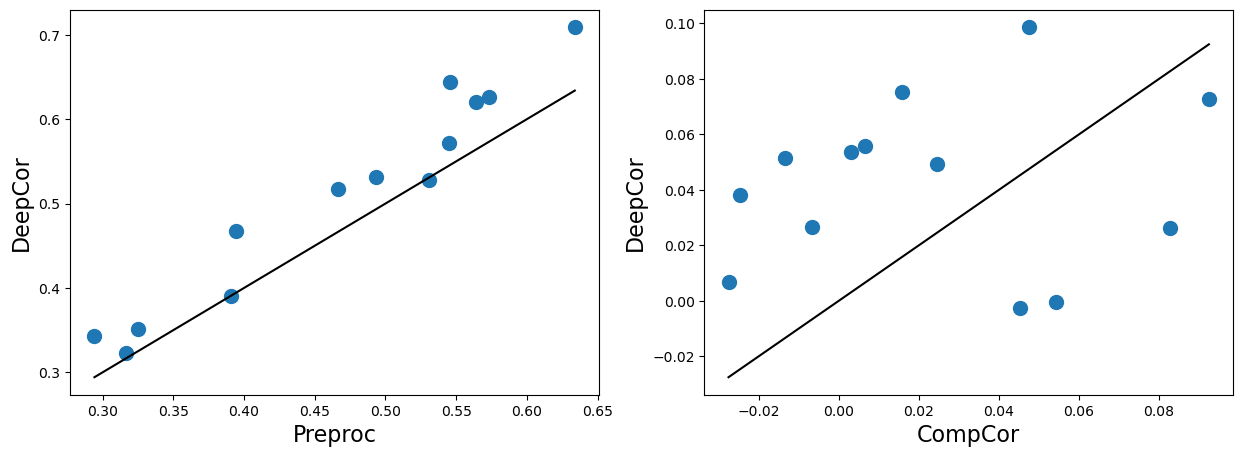

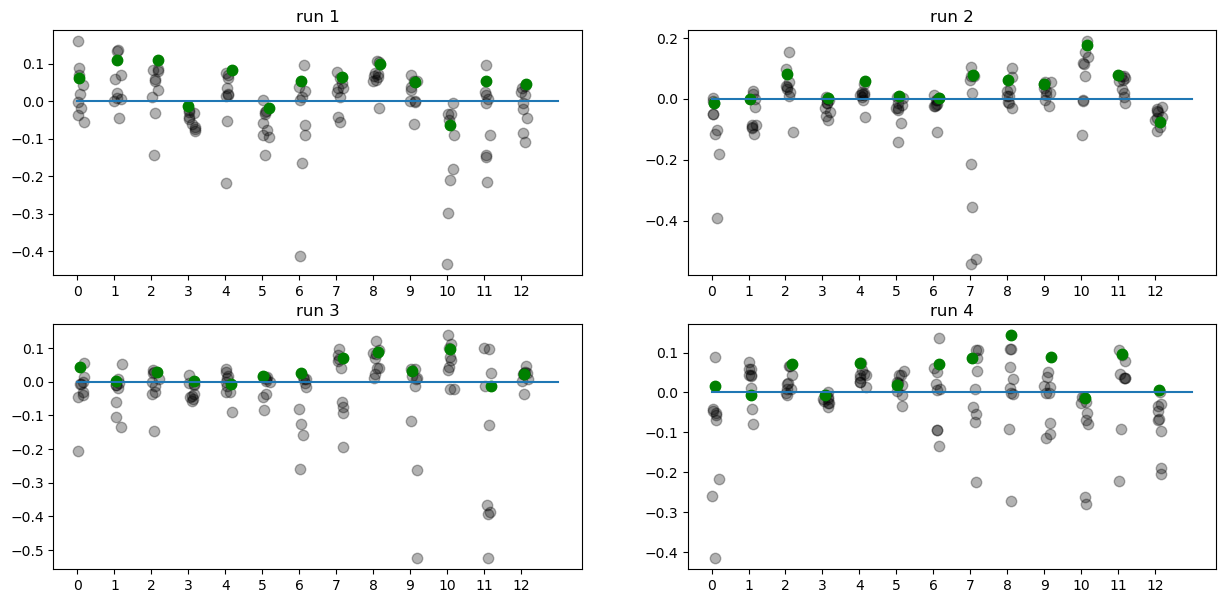

In [20]:
subs = np.arange(1,14)
reps = [1,2,3,4,6,7,8,9,10]

# subs = [0,1,2,3,4,5,6]
# reps = [1,2,3,5,6,7]
model_name = model_names[1]
print(model_name)
res = [[get_ensembled_corr(model_name,s=s,r=r,reps=reps)[0] for r in [1,2,3,4]] for s in subs]
#res = np.max(np.array([[[get_ensembled_corr(model_name,s=s,r=r,reps=reps)[0] for r in [1,2,3,4]] for s in subs] for model_name in ['conv_denoise','conv_denoise500','conv_denoise_large','conv_denoise_large500','conv_smooth','conv_smooth-small']]),axis=0)
#res = np.median(np.array([[[get_ensembled_corr(model_name,s=s,r=r,reps=reps)[0] for r in [1,2,3,4]] for s in subs] for model_name in model_names]),axis=0)
indiv = np.array([[get_ensembled_corr(model_name,s=s,r=r,reps=reps)[1] for r in [1,2,3,4]] for s in subs])

res = np.array(res)
print(res.shape)
print(indiv.shape)

pretty_t_test_rel(res.mean(axis=1)[:,0],res.mean(axis=1)[:,2],text='DeepCor > Preproc: ')
pretty_t_test_rel(res.mean(axis=1)[:,1],res.mean(axis=1)[:,2],text='DeepCor > COMPCOR: ')

diff = res-res[:,:,0][:,:,np.newaxis]
#diff = res
m = diff.mean(axis=1).mean(axis=0)
plt.bar([0,1,2],m)
plt.xticks([0,1,2],labels=[f'preproc\n{m[0]:.3f}',f'compcor\n{m[1]:.3f}',f'FG:{m[2]:.3f}'])


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
vec1=res.mean(axis=1)[:,0]
vec2=res.mean(axis=1)[:,2]
plt.plot(vec1,vec2,'.',markersize=20)
plt.plot([vec1.min(),vec1.max()],[vec1.min(),vec1.max()],'k-')
plt.xlabel('Preproc',fontsize=16)
plt.ylabel('DeepCor',fontsize=16)

plt.subplot(1,2,2)
vec1=diff.mean(axis=1)[:,1]
vec2=diff.mean(axis=1)[:,2]
plt.plot(vec1,vec2,'.',markersize=20)
plt.plot([vec1.min(),vec1.max()],[vec1.min(),vec1.max()],'k-')
plt.xlabel('CompCor',fontsize=16)
plt.ylabel('DeepCor',fontsize=16)

n = len(subs)
plt.figure(figsize=(15,7))
for r in range(4):
    plt.subplot(2,2,r+1)
    for i in range(indiv.shape[-1]):
        xs=np.arange(n)+np.random.rand(n)*.2;plt.plot(xs,indiv[:,r,i]-res[:,r,0],'k.',markersize=15,alpha=.3);
    xs=np.arange(n)+np.random.rand(n)*.2;plt.plot(xs,res[:,r,2]-res[:,r,0],'g.',markersize=15,alpha=1);
    plt.plot([0,n],[0,0]);
    #plt.plot([0,n],[res[:,r,1].mean(),res[:,r,1].mean()]);
    plt.xticks(np.arange(n));
    plt.title(f'run {r+1}')

In [17]:
# plt.figure(figsize=(15,5))
# r = 3
# ys = diff[:,r,1]-diff[:,r,2]
# plt.plot(ys,'.',markersize=20);
# plt.plot([0,12],[0,0],'k-');
# plt.xticks(np.arange(13));

In [ ]:
#np.array([load_pickle(os.path.join('./stefano-pretraining-organized/',f'{model_name}-S_{s}-R_{r}-rep_{rep}.pickle'))['signal'] for rep in reps]).mean(axis=0)